# Data Processing

## Librairies imports

In [ ]:
# using Pkg;
# Pkg.add("CSV");
# Pkg.add("Random");
# Pkg.add("DataStructures");
# Pkg.add("BenchmarkTools");
# Pkg.add("DataFrames");
# Pkg.add("Statistics");
# Pkg.add("Dates");
# Pkg.add("Gadfly");
# Pkg.add("MLBase");
# Pkg.add("DecisionTree");
# Pkg.add("GLM");

In [1]:
using CSV, DataFrames, GLM, Statistics, Dates, Gadfly, Random, MLBase, DecisionTree;
include("utils/precipitation.jl");

## Build features

### 1. Ouvrages_surverse.csv

#### ID_ouvrage, Latitude, Longitude, Height

In [6]:
ouvrages = CSV.read("data/ouvrages-surverses.csv");
colnames = ["N_Env", "ID_SOMA", "ID_OUVRAGE", "NOM", "SOMA_SEC", "REGION", "TP_X", "TP_Y", "TP_Z", "TP_LAT", "TP_LNG", "EMI_X", "EMI_Y", "EMI_LNG", "EMI_LAT"];
names!(ouvrages, Symbol.(colnames));
select!(ouvrages, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z]);

#### Replace missing Z index with mean

In [8]:
ouvrages.TP_Z = coalesce.(ouvrages.TP_Z, mean(ouvrages[completecases(ouvrages), :].TP_Z));
first(shuffleDf(ouvrages), 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z
,String,Float64,Float64,Float64
1,4230-05D,45.6728,-73.4915,11.55
2,4620-04D,45.416,-73.8844,25.09
3,4230-01D,45.6621,-73.4983,11.79
4,3460-01D,45.5061,-73.758,25.73
5,3450-01D,45.5115,-73.7546,25.87


#### Visualtion des données chargées

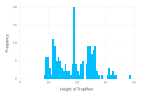

In [9]:
plot(ouvrages, x=:TP_Z, Geom.histogram(bincount=50), Guide.xlabel("Height of TropPlein"),Guide.ylabel("Frequency"))

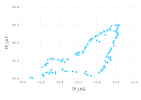

In [5]:
plot(ouvrages,x=:TP_LNG, y=:TP_LAT, Geom.point)

### 2. Surverses.csv

#### NO_ouvrage, Date, Surverse

In [10]:
surverses = CSV.read("data/surverses.csv", missingstring="-99999");

first(shuffleDf(surverses),5)

,NO_OUVRAGE,DATE,SURVERSE,RAISON
,String,Date,Int64⍰,String⍰
1,4420-02D,2016-02-23,0,missing
2,3780-01D,2018-05-30,0,missing
3,4400-02D,2013-05-09,0,missing
4,3480-01D,2015-07-09,0,missing
5,4350-01D,2016-02-18,0,missing


#### Filter months

In [11]:
surverses = filter(row -> month(row.DATE) > 4, surverses);
surverses = filter(row -> month(row.DATE) < 11, surverses);

#### Filter non rain surverses

In [12]:
raison = coalesce.(surverses[:,:RAISON],"Inconnue");
surverses[!,:RAISON] = raison;

surverses = filter(row -> row.RAISON ∈ ["P","Inconnue","TS"], surverses);
select!(surverses, [:NO_OUVRAGE, :DATE, :SURVERSE]);

#### Remove missing data and rename

In [13]:
surverses = dropmissing(surverses, disallowmissing=true);
rename!(surverses, :NO_OUVRAGE => :ID_OUVRAGE);
first(shuffleDf(surverses), 5)

,ID_OUVRAGE,DATE,SURVERSE
,String,Date,Int64
1,4350-01D,2013-06-17,0
2,4240-02D,2013-05-10,0
3,3260-01D,2016-05-31,0
4,3380-01D,2016-10-30,0
5,4250-01D,2015-07-26,0


### 3. Precipitation.csv

#### Date, Heure, McTavish, Bellevue, Assomption, Trudeau, StHubert

#### Load and filter months between May & October included

In [14]:
precipitations = CSV.read("data/precipitations.csv",missingstring="-99999");
rename!(precipitations, Symbol("St-Hubert")=>:StHubert);

precipitations = filter(row -> month(row.date) > 4, precipitations);
precipitations = filter(row -> month(row.date) < 11, precipitations); 

In [15]:
first(shuffleDf(precipitations),5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2019-05-19,19,11,0,5,5,18
2,2015-05-12,0,0,0,0,0,0
3,2014-07-24,22,0,0,0,0,0
4,2017-10-30,16,0,0,0,0,0
5,2013-05-14,1,0,0,0,0,missing


#### Replace missing data by 0

In [ ]:
#OLD WAY

#precipitation[!,:McTavish] = coalesce.(precipitation[:,:McTavish], 0);
#precipitation[!,:Bellevue] = coalesce.(precipitation[:,:Bellevue], 0);
#precipitation[!,:Assomption] = coalesce.(precipitation[:,:Assomption], 0);
#precipitation[!,:Trudeau] = coalesce.(precipitation[:,:Trudeau], 0);
#precipitation[!,:StHubert] = coalesce.(precipitation[:,:StHubert], 0);

#first(shuffleDf(precipitation), 5)

In [16]:
precipitation_by_day = by(precipitations, :date,  
                            McTavish = :McTavish=>mean_wo_missing, 
                            Bellevue = :Bellevue=>mean_wo_missing, 
                            Assomption = :Assomption=>mean_wo_missing,
                            Trudeau = :Trudeau=>mean_wo_missing,
                            StHubert = :StHubert=>mean_wo_missing)

for i=1:size(precipitations,1)
    if isequal(precipitations[i, :McTavish], missing)
        precipitations[i,:McTavish] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:McTavish][1]
    end
    if isequal(precipitations[i, :Bellevue], missing)
        precipitations[i,:Bellevue] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Bellevue][1]
    end
    if isequal(precipitations[i, :Assomption], missing)
        precipitations[i,:Assomption] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Assomption][1]
    end
    if isequal(precipitations[i, :Trudeau], missing)
        precipitations[i,:Trudeau] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:Trudeau][1]
    end
    if isequal(precipitations[i, :StHubert], missing)
        precipitations[i,:StHubert] = filter(row-> row.date == precipitations[i,:date], precipitation_by_day)[!,:StHubert][1]
    end
end

first(shuffleDf(precipitations), 5)

,date,heure,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,2018-09-12,7,0,0,0,0,0
2,2014-06-30,14,0,0,0,0,0
3,2016-06-26,1,0,0,0,0,0
4,2018-06-11,7,0,0,0,0,0
5,2013-07-30,1,0,0,0,0,0


###  Precipitation aggregation

#### Sum of precipitation for the day

In [17]:
pcp_sum = by(precipitations, :date,  
            McTavish = :McTavish=>sum, 
            Bellevue = :Bellevue=>sum,
            Assomption = :Assomption=>sum, 
            Trudeau = :Trudeau=>sum, 
            StHubert = :StHubert=>sum);
first(shuffleDf(pcp_sum), 5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2014-09-02,46,56,70,33,6
2,2017-05-24,0,0,0,0,0
3,2019-05-12,0,0,0,0,0
4,2019-05-26,3,0,21,5,7
5,2017-05-30,58,84,100,83,33


#### Representation visuelle des données enregistrées des différentes stations. 
(C'est intéractif ! Vous pouvez choisir quelles distributions voir !)

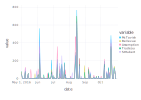

In [18]:
df_for_plot = pcp_sum
df_for_plot = filter(row -> year(row.date) == 2016, pcp_sum);
df_for_plot = melt(df_for_plot, :date)

plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

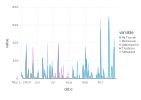

In [19]:
df_for_plot = filter(row -> year(row.date) == 2019, pcp_sum);
df_for_plot = melt(df_for_plot, :date)

plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

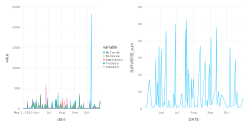

In [20]:
date_to_plot = 2013;
df_for_plot = filter(row -> year(row.date) == date_to_plot, pcp_sum);
df_for_plot = melt(df_for_plot, :date)
plt_a = plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable);

surv_to_plot = filter(row -> year(row.DATE) == date_to_plot && row.SURVERSE == 1, surverses)
select!(surv_to_plot, [:DATE, :SURVERSE])
surv_date = by(surv_to_plot, :DATE, :SURVERSE => sum)
plt_b = plot(surv_date, x=:DATE, y=:SURVERSE_sum, Geom.line);
set_default_plot_size(25cm, 13cm)
hstack(plt_a, plt_b)

In [ ]:
# first(shuffleDf(surverses), 10);
surv_to_plot = filter(row -> year(row.DATE) == 2014 && row.SURVERSE == 1, surverses)
select!(surv_to_plot, [:DATE, :SURVERSE])
surv_date = by(surv_to_plot, :DATE, :SURVERSE => sum)
plot(surv_date, x=:DATE, y=:SURVERSE_sum, Geom.line)

#### Maximum precipitation in an hour for the day

In [21]:
pcp_max = by(precipitations, :date,  
            McTavish = :McTavish=>maximum,
            Bellevue = :Bellevue=>maximum, 
            Assomption = :Assomption=>maximum,
            Trudeau = :Trudeau=>maximum,
            StHubert = :StHubert=>maximum)
first(shuffleDf(pcp_max),5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2014-07-02,0,0,20,0,0
2,2019-05-05,0,0,0,0,0
3,2017-09-06,0,0,0,0,2
4,2014-09-15,0,0,0,0,0
5,2014-05-19,0,0,0,0,0


#### Representation visuelle des données enregistrées des différentes stations

(C'est intéractif ! Vous pouvez choisir quelles distributions voir !)

In [ ]:
df_for_plot = pcp_max
df_for_plot = filter(row -> year(row.date) == 2013, pcp_max);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

In [ ]:
df_for_plot = filter(row -> year(row.date) == 2019, pcp_max);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

#### Maximum precipitation during three consecutive hours in a day

In [22]:
pcp_max3h = by(precipitations, :date,
                McTavish = :McTavish=>maximum3,
                Bellevue = :Bellevue=>maximum3,
                Assomption = :Assomption=>maximum3,
                Trudeau = :Trudeau=>maximum3,
                StHubert = :StHubert=>maximum3)
first(shuffleDf(pcp_max3h),5)

,date,McTavish,Bellevue,Assomption,Trudeau,StHubert
,Date,Int64,Int64,Int64,Int64,Int64
1,2018-07-06,32,0,49,0,25
2,2017-05-29,67,40,60,53,57
3,2015-06-19,0,0,0,0,0
4,2013-06-03,0,0,0,0,0
5,2017-10-22,0,0,0,0,0


#### Representation visuelle des données enregistrées des différentes stations

(C'est intéractif ! Vous pouvez choisir quelles distributions voir !)

In [ ]:
df_for_plot = pcp_max3h
df_for_plot = filter(row -> year(row.date) == 2018, pcp_sum);
df_for_plot = melt(df_for_plot, :date)
plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

#### Visualisation of all three agregations for 1 meteo station

In [ ]:
date_to_pt = 2018;
loc = :McTavish
mct_sum = pcp_sum[:,[1,2]]
rename!(mct_sum, loc => :Sum);
mct_sum = filter(row -> year(row.date) == date_to_pt, mct_sum);

mct_max = pcp_max[:,[1,2]]
rename!(mct_max,loc => :Max);
mct_max = filter(row -> year(row.date) == date_to_pt, mct_max);

mct_max3h = pcp_max3h[:,[1,2]]
rename!(mct_max3h,loc => :Max3h);
mct_max3h = filter(row -> year(row.date) == date_to_pt, mct_max3h);

df_for_plot = join(mct_sum, mct_max3h, on = :date);
df_for_plot = join(df_for_plot, mct_max, on = :date);
df_for_plot = melt(df_for_plot, :date)


plot(df_for_plot, x=:date, y=:value, Geom.line, color=:variable)

### Join Dataframes

In [34]:
X_test = CSV.read("data/test.csv");
rename!(X_test, :NO_OUVRAGE => :ID_OUVRAGE);

In [36]:
X_test = join(ouvrages, X_test, on =:ID_OUVRAGE);
features = join(ouvrages, surverses, on =:ID_OUVRAGE);
srv = filter(row -> row.SURVERSE == 1, features);
first(shuffleDf(srv), 10)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,SURVERSE
,String,Float64,Float64,Float64,Date,Int64
1,4230-05D,45.6728,-73.4915,11.55,2018-06-23,1
2,3310-01D,45.6139,-73.6313,19.58,2015-10-25,1
3,4300-01D,45.5707,-73.5207,13.59,2013-07-19,1
4,3350-11D,45.5328,-73.7065,25.28,2018-08-14,1
5,4380-01D,45.4677,-73.5637,19.3526,2018-05-20,1
6,4230-05D,45.6728,-73.4915,11.55,2018-10-31,1
7,4290-01D,45.5846,-73.5081,11.89,2015-06-08,1
8,3400-01D,45.5435,-73.6755,26.04,2017-10-08,1
9,0801-05D,45.5173,-73.5312,12.7,2013-07-12,1


In [ ]:
# df_for_geo_plot = filter(row -> row.DATE == Date(2018,7,25), features)
df_for_geo_plot = filter(row -> row.DATE == Date(2015, 5, 30), features)
# df_for_geo_plot = filter(row -> row.DATE == Date(2017, 10, 9), features)
df_for_geo_plot[:SURVERSE] = convert(Array{Bool,1}, df_for_geo_plot[:SURVERSE])
plot(df_for_geo_plot, x=:TP_LNG, y=:TP_LAT, Geom.point, color=:SURVERSE, Guide.title("2018-07-25, état des surverses"))
#first(df_for_geo_plot,5) 

### Add precipitation data to features

#### Get stations lat-lng

In [37]:
station_df = DataFrame(STATION = String[], LAT = Float64[], LNG = Float64[]);

push!(station_df, ["McTavish", 45.504742, -73.579167]);
push!(station_df, ["Bellevue", 45.427222, -73.929167]);
push!(station_df, ["Assomption", 45.809444, -73.434722]);
push!(station_df, ["Trudeau", 45.467778, -73.741667]);
push!(station_df, ["StHubert", 45.5175, -73.416944]);

station_df

,STATION,LAT,LNG
,String,Float64,Float64
1,McTavish,45.5047,-73.5792
2,Bellevue,45.4272,-73.9292
3,Assomption,45.8094,-73.4347
4,Trudeau,45.4678,-73.7417
5,StHubert,45.5175,-73.4169


### Augment Features

#### Add pcp_sum, pcp_max, pcp_max3 columns

In [38]:
function addColsForPrecipationPerDay(df)
    df[!, :PCP_SUM] = zeros(size(df, 1));
    df[!, :PCP_MAX] = zeros(size(df, 1));
    df[!, :PCP_MAX3] = zeros(size(df, 1));
    df[!, :METEO] = fill("", size(df, 1));
    return df
end

X_test = addColsForPrecipationPerDay(X_test)
permutecols!(X_test, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z, :DATE, :METEO, :PCP_SUM, :PCP_MAX, :PCP_MAX3]);
    
features = addColsForPrecipationPerDay(features)
permutecols!(features, [:ID_OUVRAGE, :TP_LAT, :TP_LNG, :TP_Z, :DATE, :METEO, :PCP_SUM, :PCP_MAX, :PCP_MAX3, :SURVERSE]);

first(shuffleDf(features), 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX,PCP_MAX3
,String,Float64,Float64,Float64,Date,String,Float64,Float64,Float64
1,4230-08D,45.6968,-73.4809,10.11,2016-09-03,,0.0,0.0,0.0
2,4430-04D,45.4197,-73.6487,31.54,2013-08-15,,0.0,0.0,0.0
3,4795-01D,45.4499,-73.5682,15.747,2018-10-21,,0.0,0.0,0.0
4,4710-02D,45.6976,-73.4968,12.12,2017-08-17,,0.0,0.0,0.0
5,4620-02D,45.4154,-73.8878,25.8,2016-06-19,,0.0,0.0,0.0


#### Find closest station to each ouvrage and add pcp_sum and pcp_max to it

In [39]:
function fillPrecipitationWithClosestMeteoStation(df)
    for i=1:size(df, 1)
        id_ouvrage = df[i, 1]; 
        closest_station = "McTavish"; # initial value
        shortest_dist = -1;

        # Find closest station
        for j=1:size(station_df, 1)
            dist = findDistance(df[i, :TP_LAT], df[i, :TP_LNG], station_df[j, :LAT], station_df[j, :LNG]);

            if shortest_dist == -1 || dist < shortest_dist
                shortest_dist = dist;
                closest_station = station_df[j, :STATION];
            end
        end

        # Augment comb with a weighted p_sum, based on the distance to the station
        p_sum = pcp_sum[∈([df[i, :DATE]]).(pcp_sum.date), Symbol(closest_station)];
    #     comb[i, :PCP_SUM] = p_sum[1] * (1 - shortest_dist);
        df[i, :PCP_SUM] = p_sum[1]; 

        # Augment comb with a weighted p_max, based on the distance to the station
        p_max = pcp_max[∈([df[i, :DATE]]).(pcp_max.date), Symbol(closest_station)]
    #     comb[i, :PCP_MAX] = p_max[1] * (1 - shortest_dist);
        df[i, :PCP_MAX] = p_max[1];

        # Augment comb with a weighted p_max3h, based on the distance to the station
        p_max3 = pcp_max3h[∈([df[i, :DATE]]).(pcp_max3h.date), Symbol(closest_station)]
    #     comb[i, :PCP_MAX3] = p_max3[1] * (1 - shortest_dist);
        df[i, :PCP_MAX3] = p_max3[1]; 

        df[i, :METEO] = closest_station
    end
    return df
end

fillPrecipitationWithClosestMeteoStation (generic function with 1 method)

In [40]:
X_test = fillPrecipitationWithClosestMeteoStation(X_test)
features = fillPrecipitationWithClosestMeteoStation(features)
first(shuffleDf(features), 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX
,String,Float64,Float64,Float64,Date,String,Float64,Float64
1,3767-01D,45.5456,-73.701,20.51,2017-10-27,Trudeau,0.0,0.0
2,4240-02D,45.6498,-73.4877,19.29,2018-08-12,StHubert,0.0,0.0
3,4240-02D,45.6498,-73.4877,19.29,2018-07-13,StHubert,0.0,0.0
4,4320-01D,45.5488,-73.5307,13.68,2017-06-09,McTavish,0.0,0.0
5,4620-04D,45.416,-73.8844,25.09,2018-07-19,Bellevue,0.0,0.0


#### Remove outlier in PCP_SUM and PCP_MAX AND PCP_MAX3 that cause compression

In [41]:
X_test[X_test[:PCP_SUM] .> 750, :PCP_SUM] = 750;
X_test[X_test[:PCP_MAX] .> 500, :PCP_MAX] = 500;
X_test[X_test[:PCP_MAX3] .> 750, :PCP_MAX3] = 750;

features[features[:PCP_SUM] .> 750, :PCP_SUM] = 750;
features[features[:PCP_MAX] .> 500, :PCP_MAX] = 500;
features[features[:PCP_MAX3] .> 750, :PCP_MAX3] = 750;

# first(shuffleDf(filter(row -> row.SURVERSE == 1, features)), 5)

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[41]:1
└ @ Core In[41]:1
┌ Warning: implicit broadcasting in setindex! is deprecated; use `df[row_inds, col_ind] .= Ref(v)` broadcasting assignment to change the column in place
│   caller = setindex!(::DataFrame, ::Int64, ::BitArray{1}, ::Symbol) at deprecated.jl:1490
└ @ DataFrames /home/chaime/.julia/packages/DataFrames/yH0f6/src/deprecated.jl:1490
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[41]:2
└ @ Core In[41]:2
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[41]:3
└ @ Core In[41]:3
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[41]:4
└ @ Core In[41]:4
┌ Warning: `getinde

#### TP location colored by their affiliation to its closest meteo station

In [ ]:
df_for_geo_plot = filter(row -> row.DATE == Date(2018,7,25), features)
df_for_geo_plot[:SURVERSE] = convert(Array{Bool,1}, df_for_geo_plot[:SURVERSE])
plot(df_for_geo_plot, x=:TP_LNG, y=:TP_LAT, Geom.point, color=:METEO, Guide.title("2018-07-25, Regroupement par station météo"))
#first(df_for_geo_plot,5) 

#### Ouvrage 3350-07D for 2018, when it overflow and quantity based on max3h rain fallen.

In [ ]:

# 3260-01D dans Rivière-des-Prairies
# 3350-07D dans Ahunstic
# 4240-01D dans Pointe-aux-Trembles
# 4350-01D dans le Vieux-Montréal
# 4380-01D dans Verdun

id_ouvrage_to_show = "3350-07D"
df_temp = filter(row -> row.ID_OUVRAGE ∈ [id_ouvrage_to_show], features)
df_temp = filter(row -> year(row.DATE) == 2018, df_temp);
df_temp = df_temp[!,[:ID_OUVRAGE, :DATE, :PCP_MAX3, :SURVERSE]]
df_temp[:SURVERSE] = convert(Array{Bool,1}, df_temp[:SURVERSE])



plot(df_temp, x=:DATE, y=:PCP_MAX3, Geom.point, color=:SURVERSE,Guide.title(id_ouvrage_to_show))
#first(shuffleDf(df_temp), 10)

### Split dates into months and days

In [42]:
function splitDateByMonthAndDay(df)
    df[!,:MONTH] = month.(df.DATE);
    df[!,:DAY] = day.(df.DATE);
    return df
end

X_test = splitDateByMonthAndDay(X_test)
features = splitDateByMonthAndDay(features)
first(shuffleDf(features[!, [:DATE, :MONTH, :DAY]]), 5)

,DATE,MONTH,DAY
,Date,Int64,Int64
1,2017-08-07,8,7
2,2016-10-01,10,1
3,2016-06-03,6,3
4,2015-08-07,8,7
5,2016-06-21,6,21


## Split Dataframes into train, validation and test

In [43]:
function partitionTrainTest(data, at = 0.8) # https://discourse.julialang.org/t/simple-tool-for-train-test-split/473/2
    n = nrow(data)
    idx = shuffle(1:n)
    train_idx = view(idx, 1:floor(Int, at*n))
    test_idx = view(idx, (floor(Int, at*n)+1):n)
    return data[train_idx,:], data[test_idx,:]
end


partitionTrainTest (generic function with 2 methods)

In [44]:
function standarizeTrainTestCol(X_train, X_test, col)
    mean_train_col = mean(X_train[!, col]);
    std_train_col = std(X_train[!, col]);
    X_train[!, col] = (X_train[!, col] .- mean_train_col) ./ std_train_col;
    X_test[!, col] = (X_test[!, col] .- mean_train_col) ./ std_train_col;
    
    return X_train, X_test
end
    

standarizeTrainTestCol (generic function with 1 method)

####  Standardize the PCP and Date before splitting into X_train and X_val

In [45]:
filter(row -> year(row.DATE) == 2019, features)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX,PCP_MAX3
,String,Float64,Float64,Float64,Date,String,Float64,Float64,Float64


In [90]:
X_train = filter(row-> year(row.DATE) .< 2019, features)
X_train = features

X_train, X_test = standarizeTrainTestCol(X_train, X_test, :TP_LAT)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :TP_LNG)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :TP_Z)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_SUM)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_MAX)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :PCP_MAX3)
X_train, X_test = standarizeTrainTestCol(X_train, X_test, :MONTH)
X_train_all, X_test = standarizeTrainTestCol(X_train, X_test, :DAY)

X_train, X_val = partitionTrainTest(X_train_all, 0.8)

first(shuffleDf(X_train),5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX
,String,Float64,Float64,Float64,Date,String,Float64,Float64
1,0801-04D,-0.421136,0.964028,-1.12254,2013-08-12,McTavish,-0.401294,-0.401869
2,4790-01D,-0.581332,0.825016,-0.83638,2017-10-06,McTavish,-0.401294,-0.401869
3,4370-05D,-1.15314,-0.0563688,0.789825,2016-09-14,Trudeau,-0.401294,-0.401869
4,3460-01D,-0.384379,-0.830877,0.934445,2013-05-27,Trudeau,-0.401294,-0.401869
5,3240-01D,1.4512,0.682607,-1.49025,2017-09-21,McTavish,-0.401294,-0.401869


In [91]:
first(shuffleDf(X_test),5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM
,String,Float64,Float64,Float64,Date,Categorical…,Float64
1,4350-01D,-0.465715,0.725081,-0.0467296,2019-05-29,McTavish,-0.401294
2,4350-01D,-0.465715,0.725081,-0.0467296,2019-08-12,McTavish,-0.131521
3,4240-01D,1.28137,1.24035,-1.19178,2019-05-15,StHubert,-0.401294
4,3260-01D,1.29293,0.531312,0.0790333,2019-08-25,McTavish,-0.401294
5,4380-01D,-0.828933,0.658409,-0.0467296,2019-09-12,McTavish,-0.401294


In [92]:
first(shuffleDf(X_val),5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX
,String,Float64,Float64,Float64,Date,String,Float64,Float64
1,3768-01D,0.0649893,-0.396707,0.389812,2015-09-08,Trudeau,-0.401294,-0.401869
2,4360-01D,-0.562793,0.757544,-0.693299,2018-10-03,McTavish,-0.401294,-0.401869
3,3480-04D,-0.454006,-1.05544,0.760593,2015-05-26,Trudeau,0.232673,0.453379
4,4310-01D,0.296979,0.96829,-0.880997,2014-06-04,McTavish,-0.401294,-0.401869
5,0801-01D,-0.234605,0.936104,-0.914844,2014-09-08,McTavish,-0.401294,-0.401869


###  Standardize the PCP and Date

In [ ]:
# mean_pcpsum = mean(features.PCP_SUM);
# std_pcpsum = std(features.PCP_SUM);
# features.PCP_SUM = (features.PCP_SUM .- mean_pcpsum) ./ std_pcpsum;

# mean_pcpmax = mean(features.PCP_MAX);
# std_pcpmax = std(features.PCP_MAX);
# features.PCP_MAX = (features.PCP_MAX .- mean_pcpmax) ./ std_pcpmax;

# mean_pcpmax3 = mean(features.PCP_MAX3);
# std_pcpmax3 = std(features.PCP_MAX3);
# features.PCP_MAX3 = (features.PCP_MAX3 .- mean_pcpmax3) ./ std_pcpmax3;

# meanmonth = mean(features.MONTH);
# stdmonth = std(features.MONTH);
# features.MONTH = (features.MONTH .- meanmonth) ./ stdmonth;

# meanday = mean(features.DAY);
# stdday = std(features.DAY);
# features.DAY = (features.DAY .- meanday) ./ stdday;

In [53]:
first(shuffleDf(filter(row -> row.SURVERSE == 1, features)), 5)

,ID_OUVRAGE,TP_LAT,TP_LNG,TP_Z,DATE,METEO,PCP_SUM,PCP_MAX
,String,Float64,Float64,Float64,Date,String,Float64,Float64
1,3350-09D,-0.0251308,-0.486079,0.625204,2017-08-15,Trudeau,0.529423,1.33917
2,4370-04D,-1.18852,-0.458815,1.01137,2018-09-26,Trudeau,0.138252,0.209022
3,0801-05D,-0.254625,0.907701,-1.07023,2018-06-18,McTavish,3.36204,2.74422
4,4265-01D,1.00593,1.15342,-1.21178,2018-08-08,StHubert,0.610355,0.514468
5,0801-05D,-0.254625,0.907701,-1.07023,2013-07-08,McTavish,-0.266407,-0.0964234


# Logistic Regression

In [ ]:
# categorical!(X_train, :METEO)
# levels(X_train[:, :METEO])

In [54]:
names_glm = [:TP_LAT, :TP_LNG, :TP_Z, :MONTH, :DAY, :PCP_SUM, :METEO, :SURVERSE];
names(X_train)

12-element Array{Symbol,1}:
 :ID_OUVRAGE
 :TP_LAT    
 :TP_LNG    
 :TP_Z      
 :DATE      
 :METEO     
 :PCP_SUM   
 :PCP_MAX   
 :PCP_MAX3  
 :SURVERSE  
 :MONTH     
 :DAY       

In [55]:
val_form = @formula(SURVERSE ~ TP_LAT + TP_LNG + TP_Z + MONTH + DAY + PCP_SUM + METEO);
val_model = glm(val_form, X_train, Bernoulli(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Bernoulli{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

SURVERSE ~ 1 + TP_LAT + TP_LNG + TP_Z + MONTH + DAY + PCP_SUM + METEO

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                   Estimate  Std. Error    z value  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)      -5.80895    0.102682    -56.5724     <1e-99  -6.0102      -5.60769  
TP_LAT            0.176607   0.0252632     6.99068    <1e-11   0.127092     0.226122 
TP_LNG            0.871877   0.0493312    17.674      <1e-69   0.77519      0.968565 
TP_Z             -0.101894   0.0245458    -4.15119    <1e-4   -0.150003    -0.0537855
MONTH            -0.0908793  0.016963     -5.35749    <1e-7   -0.124126    -0.0576324
DAY             

In [56]:
val_labels = X_val[!, :SURVERSE];
val_pred = GLM.predict(val_model, X_val);

threshold = 0.07;
val_pred[val_pred .>= threshold] .= 1.0;
val_pred[val_pred .< threshold] .= 0.0;
val_pred = convert(Array{Int}, trunc.(val_pred));

r = roc(val_labels, val_pred);
f1score(r)

0.3494335122242099

In [77]:
names_glm = [:SURVERSE, :TP_LNG, :TP_Z, :MONTH, :PCP_SUM, :METEO];
val_form = @formula(SURVERSE ~ TP_LNG + TP_Z + MONTH + PCP_SUM + METEO);
names(X_train)

12-element Array{Symbol,1}:
 :ID_OUVRAGE
 :TP_LAT    
 :TP_LNG    
 :TP_Z      
 :DATE      
 :METEO     
 :PCP_SUM   
 :PCP_MAX   
 :PCP_MAX3  
 :SURVERSE  
 :MONTH     
 :DAY       

In [82]:
niter = 20;
batch_score = 0;
batch_threshold = 0;

for i=1:niter
    # Split train and val sets
    X_train_glm, X_val_glm = partitionTrainTest(X_train_all, 0.8);
    
    # Build features and labels
    train_features = X_train_glm[:, names_glm];
    
    # Build model
    val_model = glm(val_form, train_features, Bernoulli(), LogitLink())
    
    # Validate model
    val_features = X_val_glm[:, names_glm];
    val_labels = X_val_glm[!, :SURVERSE];
    
    # Get best threshold
    start_threshold = 0.090;
    max_threshold = 0.095;
    step = 0.0002;
    
    best_threshold = start_threshold;
    score = -1;
    
    # Get best threshold
    for j=start_threshold:step:max_threshold
        val_pred = GLM.predict(val_model, val_features);
        val_pred[val_pred .>= j] .= 1.0;
        val_pred[val_pred .< j] .= 0.0;
        val_pred = convert(Array{Int}, trunc.(val_pred))
        
        r = roc(val_labels, val_pred);
        new_score = f1score(r);
        
        if new_score > score
            score = new_score
            best_threshold = j
        end
    end
    
    batch_score += score;
    batch_threshold += best_threshold;
end

batch_threshold = batch_threshold / niter;
batch_score = batch_score / niter

0.3778542694464081

In [83]:
batch_threshold

0.09326999999999999

#### Full train

In [84]:
submit_features = X_train_all[:, names_glm];
submit_labels = X_train_all[:, :SURVERSE];

In [85]:
model = glm(val_form, submit_features, Bernoulli(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Bernoulli{Float64},LogitLink},GLM.DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

SURVERSE ~ 1 + TP_LNG + TP_Z + MONTH + PCP_SUM + METEO

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                   Estimate  Std. Error    z value  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)      -5.51761    0.0825639   -66.8284     <1e-99  -5.67944   -5.35579 
TP_LNG            0.842969   0.0437174    19.2822     <1e-82   0.757284   0.928653
TP_Z             -0.128908   0.0224628    -5.73873    <1e-8   -0.172935  -0.084882
MONTH            -0.0813975  0.015125     -5.38164    <1e-7   -0.111042  -0.051753
PCP_SUM           0.759434   0.00831146   91.3719     <1e-99   0.743143   0.775724
METEO: Bellevue   0.872065   0.185093      4.71149    <

In [86]:
categorical!(X_test, :METEO)
levels(X_test[:, :METEO])

┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = catvaluetype at array.jl:614 [inlined]
└ @ Core /home/chaime/.julia/packages/CategoricalArrays/xjesC/src/array.jl:614


3-element Array{String,1}:
 "McTavish"
 "StHubert"
 "Trudeau" 

In [87]:
test_features = X_test[:, setdiff(names_glm, [:SURVERSE])]
test_labels = GLM.predict(val_model, test_features);
test_labels[test_labels .>= batch_threshold] .= 1.0;
test_labels[test_labels .< batch_threshold] .= 0.0;
test_labels = convert(Array{Int}, trunc.(test_labels))

283-element Array{Int64,1}:
 0
 0
 1
 0
 0
 1
 0
 0
 0
 0
 0
 1
 0
 ⋮
 0
 1
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0

### Submission

# Random Forest

In [94]:
X_train_rf = X_train;
X_val_rf = X_val;
X_test_rf = X_test;
X_train_all_rf = X_train_all;

In [95]:
X_train_rf[:, :METEO] = broadcast(convert_meteo, X_train[:, :METEO]);
X_val_rf[:, :METEO] = broadcast(convert_meteo, X_val[:, :METEO]);
X_test_rf[:, :METEO] = broadcast(convert_meteo, X_test[:, :METEO]);
X_train_all_rf[:, :METEO] = broadcast(convert_meteo, X_train_all[:, :METEO]);

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[95]:1
└ @ Core In[95]:1
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[95]:2
└ @ Core In[95]:2
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[95]:3
└ @ Core In[95]:3
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[95]:4
└ @ Core In[95]:4


In [118]:
names_ft = [:TP_LAT, :TP_LNG, :TP_Z, :MONTH, :METEO, :PCP_SUM, :PCP_MAX, :PCP_MAX3];
nft = 5;
ntrees = 120;
podata = 0.85;
maxd = 28;
train_features = convert(Matrix{Float64},X_train_rf[:, names_ft]);
train_labels = X_train_rf[:, :SURVERSE];

#### Single validation

In [116]:
val_model = build_forest(train_labels, train_features, nft, ntrees, podata, maxd)

Ensemble of Decision Trees
Trees:      120
Avg Leaves: 2361.391666666667
Avg Depth:  25.0

In [119]:
val_model = build_forest(train_labels, train_features, nft, ntrees, podata, maxd)
val_features = convert(Matrix{Float64},X_val_rf[:, names_ft]);
val_labels = X_val_rf[!, :SURVERSE];
val_pred = apply_forest(val_model, val_features);

r = roc(val_labels, val_pred);
f1score(r)

0.6408488063660478

#### Batch validation

In [ ]:
niter = 10;
batch_score = 0;

for i=1:niter
    # Split train and val sets
    X_train_rf, X_val_rf = partitionTrainTest(X_train_all_rf, 0.8);
    
    # Build features and labels
    train_features = convert(Matrix{Float64},X_train_rf[:, names_ft]);
    train_labels = X_train_rf[:, :SURVERSE];
    
    # Build model
    val_model = build_forest(train_labels, train_features, nft, ntrees, podata, maxd);
    
    # Validate model
    val_features = convert(Matrix{Float64},X_val_rf[:, names_ft]);
    val_labels = X_val_rf[!, :SURVERSE];
    val_pred = apply_forest(val_model, val_features);

    r = roc(val_labels, val_pred);
    batch_score += f1score(r);
end

batch_score = batch_score / niter

#### Train on all data

In [120]:
submit_features =  convert(Matrix{Float64}, X_train_all_rf[:, names_ft]);
submit_labels = X_train_all_rf[:, :SURVERSE];
model = build_forest(submit_labels, submit_features, nft, ntrees, podata, maxd)

test_features = convert(Matrix{Float64},X_test_rf[:, names_ft]);
test_labels = apply_forest(model, test_features)

283-element Array{Int64,1}:
 0
 0
 1
 0
 0
 1
 0
 0
 0
 1
 0
 1
 0
 ⋮
 0
 1
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [121]:
ID = X_test_rf[:,:ID_OUVRAGE].*"_".*string.(X_test_rf[:,:DATE])
sampleSubmission = DataFrame(ID = ID, Surverse=test_labels)
CSV.write("submissions/mc-submission-16.csv",sampleSubmission)

"submissions/mc-submission-16.csv"